# 4. Sampling with MCMC

## What, exactly, is a sampler?

If you asked me a while ago what MCMC was, I might have answered that it is a tool for fitting models to data. And while it's true that MCMC is good for this general task, known as *inference*, we can actually take a step back and understand Monte Carlo schemes from a more basic standpoint.

*MCMC is a method for solving integrals.*

Let me break that down a bit more. MCMC is a *sampling algorithm*. It generates samples from what we refer to as a *posterior*, but for the moment we can simply think of it as some function. By sampling, I mean the most naive thing possible --- like drawing balls from a bucket. If I define some function $f(x)$, and I start evaluating $f(x)$ at various points $x_i$, that is a sampling. What makes what we're going to do here more special is the statistical properties of those samples, for the problems at hand. 

## Solving integrals

In some sense, the only thing that MCMC is truly meant for is sampling pdfs (probability density functions). But that sounds super abstract. So let's think about this in more real terms. Let's say I want to integrate a function, 


$$
I = \int_{a}^{b}f(x)dx
$$

If I asked you to integrate $f(x)$, what would you do? Well, it depends on what $f(x)$ is, right? If 

$$
f(x) = x^2, 
$$
you would simply tell me that 

$$
I = \int_{a}^{b}f(x)dx = \int_{a}^{b}x^2 dx = \frac{b^3}{3} - \frac{a^3}{3}
$$

Now let's imagine that $f(x)$ is *ugly*. Ugly like one of those functions you derive halfway through a problem on a Physics midterm and you realize something must not be right because there's *no way* you can integrate *that* ugly expression on this test (or indeed, ever). 


What then?

Well, usually the answer would be either "Wolfram Alpha" or, more generally, "Numerical Integration". Numerical integration says, "I can estimate the area under this complex curve by chunking it into finite rectangles/trapazoids/etc. and then calculate a sum". You've probably heard of (or used some of these methods): midpoint rule, trapezoidal rule, simpsons rule, Gaussian quadrature... (many of these are implemented in the `scipy.integrate` module).

When you're dealing with a (relatively) well behaved function in one dimension, those methods are often the way to go (and the first thing we jump to in our code). But what happens if our problem is not one dimensional? What if, for example, $f$ is a function of three spatial quantities and three additional parameters,

$$
f(\theta) = f(x,y,z,a,b,c)
$$

We now have $\theta$ as a vector of six parameters, meaning our integral looks more like 

$$
I = \int \int \int \int \int \int f(x,y,z,a,b,c) dx\hspace{1pt} dy\hspace{1pt} dx\hspace{1pt} da\hspace{1pt} db\hspace{1pt} dc
$$

We can now ask ourselves, *Can our above numerical integration schemes handle this?*

Each scheme above has an associated error, which comes from how the scheme is integrated. From Calculus, you probably remember that the trapezoid rule usually produces smaller errors than the midpoint rule, as it better approximates the curve being traced. We can actually write down how the error of each of these scales. I'll use the Trapezoid rule here. 

$$
\epsilon \propto \frac{1}{N^{2/d}}
$$
where $N$ is the number of sample points (i.e., how fine our grid where we evaluate our trapezoid) and $d$ is the number of dimensions being integrated over.

 This is a big problem. The error in our numerical solution to the integral scales to a power of the dimensions being integrated over, which requires us to have intractably large values of $N$ to get accurate results. This is often referred to as "the curse of dimensionality." 

So how do we get around this? 

What if instead of trying to "grid up" this multidimensional space and evaluate our function at each location, I simply "threw a dart" at a random location and evaluated it there? It turns out, you can show that the error in such a sampling method has an error of 

$$
\epsilon \propto \frac{1}{N^{1/2}}
$$


Amazingly, this does not have any dependence on dimensionality! So doing a little math with the trapizoid-rule error above, we can see that for problems with dimensionality greater than ~$d=4$ (for this rule, and closer to $d=6-8$ for, e.g., Simpson's rule), the error properties of an MCMC algorithm win out, and make the integration tractable.

## But how does the integral actually get computed?

Let's back up for a moment to the 1D case of $f(x)$ to aid in our visualization. If I draw some arbitrary function $f(x)$ across my plot, I can evaluate the integral (area) by any of the tools above. 

I could also sample, which in the absolute first order case means choosing random $\sim U(a,b)$ (uniformly drawn) values over the bounds of the integrand (i.e., in the 1D case here, values of $x$ between $a$ and $b$), and then evaluate $f(x)$ at those values. This is, quite literally, throwing darts to pick values (and where the method gets the Monte Carlo part of it's name).

Imagine I have my function $f(x)$ that looks like this

<img src="fx.png" width='400'/>

My sampling, as I described it above, corresponds to something like

<img src="fx_samples.png" width='350'/>

where the four points $x_i$ are presumed to have been drawn from some random uniform distribution. (so more likely, they will not be in ascending order of $x$).

To estimate the area under the curve, I create a rectangle for each sample $f(x_i)$ with with a width of $(b-a)$ and a height of $f(x_i)$. For example, for $f(x_1)$ above, this would look like 

<img src="fx1_area.png" width='350'/>

while the rectangle for $f(x_3)$ would look like 

<img src="fx3_area.png" width='360'/>

We can see that sometimes I overestimate the area, and other times I underestimate it. However, I will claim here, and prove below, that the *expectation value* (i.e., the *average*) of all of these rectangles represents an accurate estimate of the integral of the function $f(x)$. 

In short, I'm asserting for the moment that the expectation value by the normal integral, i.e., 
$$
\int f(x)p(x)dx.
$$
Is going to be approximated by 
$$
E_{p(\theta)}[f(\theta)] =  \int f(\theta)p(\theta)d\theta \approx \frac{1}{K}\sum_{k=1}^{K}\frac{f(\theta_k)}{p(\theta_k)}
$$

Let's explain why. In the case of a Uniform distribution, we know that our $p(\theta_k)$ is given by, simply 

$$
p(\theta_k) = \frac{1}{b-a}
$$

That is, a uniform over some bounds is normalized at the level $1/(b-a)$ such that the area of the distribution is properly normalized to 1.

Recall I computed my rectangle areas as the width $(b-a)$ times the height of the function at different sample locations. I'm thus approximating my integral as 

$$
I \approx \frac{1}{K}\sum_{k=1}^{K}f(x_k)(b-a)
$$

Notice though, that $(b-a)$ is just $1 / p(x)$ as we've defined it. Thus we can write our sum as we did above. But why does that work? I.e., can we show that this formula actually esimates the integral? 

Let's look at the *expectation value* of the estimated integral $I$. Remember, every time I use my MCMC estimator above, I'll get a somewhat different answer because I drew random points. What we want is the mean value of many estimates of the integral, $\langle I\rangle$, to *be* the integral's value given enough samples. This is something I can show.

The expectation value for $I$, by the normal formula, is given by 

$$
\langle I \rangle = \int I(x)p(x)dx = \int\left[ \frac{1}{K}\sum_{k=1}^{K}\left(\frac{f(x_k)}{p(x_k)}\right)\right]p(x) dx=E\left[ \frac{1}{K}\sum_{k=1}^{K}\left(\frac{f(x_k)}{p(x_k)}\right)\right]
$$
plugging in the expression for $I$ that I asserted above.

By Lebesgue's dominated convergence theorem, (in the limit as K goes to $\infty$), we can move the expectation value inside the sum, such that 
$$
\langle I \rangle = E\left[ \frac{1}{K}\sum_{k=1}^{K}\left(\frac{f(x_k)}{p(x_k)}\right)\right] 
$$
$$
= \frac{1}{K}\sum_{k=1}^{K}E\left[\left(\frac{f(x_k)}{p(x_k)}\right)\right]
$$

where since the expectation value for any particular $f(x_k)/p(x_k)$ does not depend on $k$, and is just the expectation value over the region, we can pull it out of the sum:
$$
= E\left[\frac{f(x)}{p(x)}\right]\frac{1}{K}\sum_{k=1}^{K} 1
$$
$$
=E\left[\frac{f(x)}{p(x)}\right]\frac{1}{K}K
$$

$$
= E\left[\frac{f(x)}{p(x)}\right]
$$
which, by the definition of expectation values, is just 
$$
 = \int \frac{f(x)}{p(x)}p(x) dx 
$$
$$
\langle I \rangle = \int f(x)dx 
$$

It confused me for quite some time to think about what the expectation value on some quantity $f(x_i)/p(x_i)$ looks like, as these are just numbers. But, recall, we are talking about the expectation value $\langle I \rangle$, which is computed over many *simulations* of I (i.e., running our sampler many times). 

Thinking about it this way, we can see that the first term in our sum, for example, 

$$
\left[\frac{f(x_0)}{p(x_0)}\right]
$$
will be *different* every time I run the sampler (since the $x_0$ is a randomly generated number).

Thus the value inside this expecation can take *any* value allowed on $f(x)$ given the set definite boundaries. It then becomes more clear that for this particular term in the sum, the expectation value *must* just be the expectation value of the function over the bounds. This is then true for *every* term in the sum.

Of course, we've based this derivation on a limit as $K\rightarrow\infty$, but in reality we are taking finite numbers of samples. There thus raises a question of "how many samples are needed for my approximation to be accurate?" This gets either into deep mathematics or pure heuristics, so I'll simply say for now that we take as many samples as is feasible, and in general if we have many independent samples we are doing O.K.

It's useful to point out here that when doing *inference* problems, we're often trying to integrate something that looks like the expectation value above, i.e., the integral of a likelihood times a prior. 


## Simple Monte Carlo

In the simplest case (Monte Carlo) we simply draw random (uniform) values of $\theta$ and compute the expectation value using the sum. We then use that expectation value, and the bounds of our integral, to solve for the area. 

For example, let's take 

$$
f(x) = x^2
$$

and I want to integrate from 1 to 2, 

$$
I = \int_{1}^{2}x^2 dx
$$

Obviously we know the answer to this is $8/3 - 1/3 = 7/3$. Let's solve it using Monte Carlo:  

In [2]:
import numpy as np 
from scipy import stats
import matplotlib.pyplot as plt

unif = stats.uniform(1,1) #this creates a uniform over the range [1,2]

def f(x):
    return x**2

sample_sum = 0
N = 1000
for i in range(N):
    s = unif.rvs()
    call = f(s)
    sample_sum += call
    
sample_sum /= N
print("integral as estimated from 1000 Samples: {}".format(sample_sum))

integral as estimated from 1000 Samples: 2.3081404190522363


We know that the true value is 2.33 repeating, here we can see that with 1000 samples, we estimate the integral to be 2.32. 

We can also try with a much (somewhat absurdly) higher N:

In [7]:
N = 100000
for i in range(N):
    s = unif.rvs()
    call = f(s)
    sample_sum += call
    
sample_sum /= N
print("integral as estimated from 100,000 Samples: {}".format(sample_sum))

integral as estimated from 100,000 Samples: 2.329695672498891


We can see that in this case we're very close, with the trailing digits rounding effectively to 2.33. 

I mentioned above that the error in our estimate of the integral in this Monte Carlo scheme scaled as $\propto N^{-1/2}$. We can write this more formally as 

$$
\epsilon = kN^{-1/2}
$$

where $k$ is a constant that captures the normalization of our scaling relation. Our goal at this point is to bring $k$ down as much as possible, so that our scaling with error has a lower normalization. (In the parlance of the expectation value $\langle I \rangle$ above, we want to reduce the *variance* in the estimates of I for any given sampling run.



## Importance Sampling 



Imagine you have a distribution that looks something like a Gaussian, defined at some range, like below:

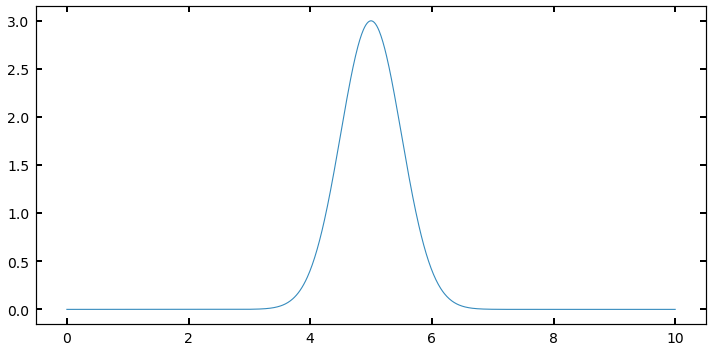

In [51]:
def f2(x):
    out = 3 * np.exp(-(x-5.)**2/(2*0.5**2))
    return out

xx = np.linspace(0,10,1000)
y = f2(xx)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(xx,y);

I could sample this function using a $\sim U(0,10)$. But many of my samples would be "wasted" because they would be sampling regions (like between 0 and 3, or 8 and 10) where the value of $f(x)$ is very small, and thus the contribution to the integral is negligable. What if I had a way to throw darts that were more likely to land near 5, where I want to be well-sampled, and not as much near 10?  

In order to improve my $k$ value, and assign some *importance* to some values of $\theta$ (in this case x) to sample over others, I need a new probability distribution to sample from that isn't just the Uniform. Thinking about this for a moment, it would seem like the obvious choice is in fact, $f(x)$ itself, (or rather, f(x) normalized such that it is a probability density function). 

This would naturally capture what I want to do: where f(x) is larger, the pdf will be larger, and the chance of drawing values there will be larger than elsewhere were f(x) is smaller. In this case, instead of a pdf that is just $1/(b-a)$, we will plug a real pdf into our sampling expression:

$$
\int g(\theta)p(\theta)d\theta \approx \frac{1}{K}\sum_{k=1}^{K}\frac{g(\theta_k)}{p(\theta_k)}
$$

Let's try setting up a problem using a Gaussian like above, and sample from a pdf that is the gaussian itself. 
- I'll set up my "arbitrary" function to return something that is gaussian shaped, but arbitrarily normalized. 
- I then set my "pdf" distribution to be a true, normalized normal distribution at the same ($\mu,\sigma$) (if we don't know these values, we can approximate them). 
- I repeat the exercise from before, normalizing each evaluation of my function by an evaluation of the proposal pdf at the same value

In [53]:
#f(x) is not normalized, it's just something with a gaussian form, as I've multiplied by a constant
def f2(x):
    return 3 * np.exp(-(x-5.)**2/(2*0.5**2))

gauss = stats.norm(5,0.5) #this is my new p(theta)
N=100000
area = []
for i in range(N):
    val = gauss.rvs()
    call = f2(val) / gauss.pdf(val)
    area.append(call)
    
norm_area = np.sum(area) / N

print('Calculated Area: {}'.format(norm_area))


Calculated Area: 3.759942411946498


We know analytically that the area we should get is 

$$
\int_{-\infty}^{\infty} a e^{-(x-b)^{2} / 2 c^{2}} d x=a\sqrt{2\pi c^2}
$$


where here, a is 3, b is 5, and c is 0.5. This gives me a computed analytical value of:

In [35]:
area_theoretical = np.sqrt(2*np.pi*0.5**2)*3
area_theoretical

3.7599424119465006

We can see that once again we've gotten the answer almost exactly right. Note that this didn't only work because both my sampling distribution and pdf were Gaussians with different normalization. Any $f(x)$ that looked roughly like a "bump" could have been estimated this way. I simply chose a Gaussian because we could compare to an analytical solution.

Now that we understand qualitatively how this process works with some simple 1D integrals, let's go back to thinking about ugly, multidimensional integrals. In the above situation, I was able to set a sampling distribution to be my target distribution because I knew the functional form of $f(x)$ completely. Now, if I knew it was a Gaussian but didn't know $(\mu,\sigma)$ I would have just run an optimizer on $f(x)$ first to find the maximum, and perhaps chosen a reasonably wide spread. 

But in the tougher cases, perhaps all I know is how to *evaluate* $f(\theta)$ for some multidimensional vector $\theta$, but know almost nothing about the details or shape of the distribution I'm trying to integrate. Above, I chose samples preferentially at higher likelihood because I knew ahead of time where those points would be. If I don't I can write an algorithm to sort that out for me. 

# Metropolis-Hastings MCMC

We're now getting into the real meat of MCMC. I hope that taking the time to walk through the simpler cases above allows the following to be more clear!

The Metropolis-Hastings algorithm alows you to create a **chain** of evaluations of your function, which don't depend on the initial conditions, but rather only on the evaluation immediately before. This biased "walker" is programmed to move loosely towards areas of higher probability, but occasionally will also move towards lower probability. This walker moves in "steps" that are usually a small sphere around its current location in parameter space. This allows us to very efficiently sample from the high-probability (or in terms of the integral, most important regions) *even if we don't have intimate knowledge of what that region looks like*. Our only requirement at this point is that we can evaluate our function at some position $\theta$ and that our function as usual is positively defined over the bounds. 

Here is the schematic:

- First, pick an initial value of $\theta$ and evaluate it as above. Add this to a stored "chain" of values
- Next, pick a $\theta^\prime$ from the *proposal pdf,* a pdf distribution centered on $\theta$ (more on this below)
- pick a number $r$ from a $Unif(0,1)$
- if $f(\theta^\prime)/f(\theta) > r$, then move to that position and add it to the chain
- otherwise, the next position in the chain is set to be the current position (and it is added to the chain again)

What do I mean by a proposal pdf? Our walker needs to know how to choose a step to take. The easiest, and most statistically simple, method for doing this is a Gaussian (multivariate if $\theta$ is multivariate) with a mean of $\mu=\theta$ and some spread $\sigma$ that is chosen for each given problem by the amount of parameter space being covered and how sharply $f$ varies. We'll discuss the exact choice of $\sigma$ more later.